## Setup

In [1]:
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import math
import seaborn as sns
from sklearn.model_selection import KFold
from tqdm import tqdm
import copy

## Hiperparâmetros

In [2]:
EPOCHS = 5
BATCH_SIZE = 1
LEARNING_RATE = 0.01
VALIDATION_RATE = 0.2

NUM_CLASSES = 10
INPUT_SHAPE = (28, 28, 1)

# Divisão do KFold
K = 2

## MNIST dataset

In [3]:
# Carregamento dos dados, separando em treinamento e teste de acordo com o Keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Escalonamento das imagens para que estejam todas no intervalo [0, 1]
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Imagens deve ter tamanho (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Distribuição dos Dados

In [4]:
# Me certifico de que o conjunto de dados de treinamento está balanceado
labels = y_train.tolist() # + y_test.tolist()

In [5]:
len(labels), Counter(labels)

(60000,
 Counter({5: 5421,
          0: 5923,
          4: 5842,
          1: 6742,
          9: 5949,
          2: 5958,
          3: 6131,
          6: 5918,
          7: 6265,
          8: 5851}))

In [6]:
# Conversão das classes para vetores binários
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

## Classe Auxiliar

In [7]:
class LossHistory(keras.callbacks.Callback):
    '''Classe para armazenar os valores de erro e acurácia por batch'''
    
    def __init__(self):
        super(keras.callbacks.Callback, self).__init__()
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        self.accuracy_train = []
        self.losses_train = []

    def on_train_begin(self, logs={}):
        '''
          Função de inicialização dos arrays
          no início do treinamento de uma época
        '''

        # Métricas durante o treinamento
        self.losses = []
        self.accuracy = []

        # Métricas de validação
        self.val_losses = []
        self.val_accuracy = []
        self.losses_train = []
        self.accuracy_train = []

    def on_batch_end(self, batch, logs={}):
        '''
          Função que armazena os valores
          de erro e acurácia em cada batch
        '''

        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('accuracy'))

        # score = model.evaluate(self.validation_data[0], self.validation_data[1])
        # self.val_losses.append(score[0])
        # self.val_accuracy.append(score[1])
    
    def on_epoch_end(self, epoch, logs={}):
      '''
          Função que armazena os valores
          de erro e acurácia em cada época
      '''
      self.losses_train.append(logs.get('loss'))
      self.accuracy_train.append(logs.get('accuracy'))

      self.val_losses.append(logs.get('val_loss'))
      self.val_accuracy.append(logs.get('val_accuracy'))

## CNN

In [8]:
# Definição do modelo usado nos experimentos
model = keras.Sequential(
    [
        keras.Input(shape=INPUT_SHAPE),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2704)              0         
                                                                 
 dense (Dense)               (None, 100)               270500    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 271,670
Trainable params: 271,670
Non-trainable params: 0
__________________________________________________

In [9]:
# Compilação do modelo com função de erro e algoritmo de otimização
model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

all_losses, all_accuracy = [], []
all_losses_train, all_accuracy_train = [], []
all_val_losses, all_val_accuracy = [], []

print(f'k = {K}')

kf = KFold(n_splits=K)
for train_index, val_index in tqdm(kf.split(x_train,y_train)):
  X_train = x_train[train_index]
  Y_train = y_train[train_index]

  X_val = x_train[val_index]
  Y_val = y_train[val_index]

  history = LossHistory()
  model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, Y_val), callbacks=[history])

  all_losses.append(history.losses)
  all_accuracy.append(history.accuracy)

  all_losses_train.append(history.losses_train)
  all_accuracy_train.append(history.accuracy_train)

  all_val_losses.append(history.val_losses)
  all_val_accuracy.append(history.val_accuracy)

all_losses = np.sum(np.array(all_losses), axis=0)/K
all_accuracy = np.sum(np.array(all_accuracy), axis=0)/K

all_losses_train = np.sum(np.array(all_losses_train), axis=0)/K
all_accuracy_train = np.sum(np.array(all_accuracy_train), axis=0)/K

all_val_losses = np.sum(np.array(all_val_losses), axis=0)/K
all_val_accuracy = np.sum(np.array(all_val_accuracy), axis=0)/K

k = 2


0it [00:00, ?it/s]

Epoch 1/5
60000/60000 [==============================] - 241s 4ms/step - loss: 0.1554 - accuracy: 0.9515 - val_loss: 0.0665 - val_accuracy: 0.9786
Epoch 2/5
60000/60000 [==============================] - 272s 5ms/step - loss: 0.0564 - accuracy: 0.9829 - val_loss: 0.0404 - val_accuracy: 0.9868
Epoch 3/5
60000/60000 [==============================] - 235s 4ms/step - loss: 0.0356 - accuracy: 0.9885 - val_loss: 0.0209 - val_accuracy: 0.9942
Epoch 4/5
60000/60000 [==============================] - 273s 5ms/step - loss: 0.0227 - accuracy: 0.9924 - val_loss: 0.0293 - val_accuracy: 0.9900
Epoch 5/5
60000/60000 [==============================] - 302s 5ms/step - loss: 0.0151 - accuracy: 0.9953 - val_loss: 0.0069 - val_accuracy: 0.9981


1it [22:02, 1322.74s/it]

Epoch 1/5
60000/60000 [==============================] - 288s 5ms/step - loss: 0.0092 - accuracy: 0.9970 - val_loss: 0.0050 - val_accuracy: 0.9986
Epoch 2/5
60000/60000 [==============================] - 275s 5ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.0113 - val_accuracy: 0.9960
Epoch 3/5
60000/60000 [==============================] - 233s 4ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.0032 - val_accuracy: 0.9990
Epoch 4/5
60000/60000 [==============================] - 225s 4ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 9.9517e-04 - val_accuracy: 0.9997
Epoch 5/5
60000/60000 [==============================] - 225s 4ms/step - loss: 8.2943e-04 - accuracy: 0.9998 - val_loss: 0.0012 - val_accuracy: 0.9998


2it [42:49, 1284.52s/it]


## Gráficos

### Plot por Batch

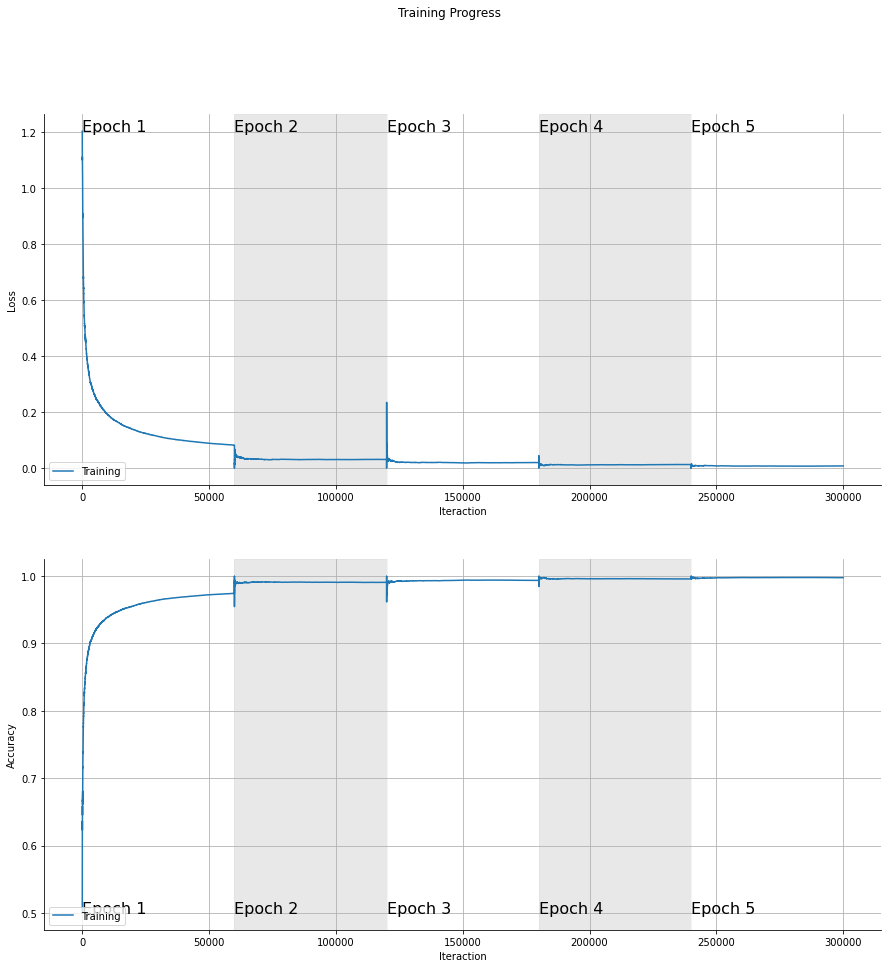

In [10]:
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(15, 15))

# O número de iterações durante o treinamento é dado pelo 
# tamanho do conjunto de treinamento e o tamanho do batch
N_INTERACTIONS = math.ceil(len(x_train)/BATCH_SIZE)

# Os valores do eixo são o total de iterações com 
# o número de épocas, já que queremos o eixo x
# por batches
x = range(0, (N_INTERACTIONS*EPOCHS))

# A cada final de época, o sombreado é desfeito
color = 'white'
for i in range(0, (N_INTERACTIONS*EPOCHS), N_INTERACTIONS):
  ax1.axvspan(i, i+N_INTERACTIONS, color=color, alpha=0.5)
  ax1.text(i, max(all_losses), f'Epoch {1+(i // N_INTERACTIONS)}', fontsize=16, color='black')
  color = 'lightgray' if color == 'white' else 'white'

# Plot dos erros coletados usando KFold
ax1.plot(x, all_losses)

fig.suptitle('Training Progress')
ax1.set(xlabel='Iteraction', ylabel='Loss')
ax1.legend(['Training'], loc='lower left')
ax1.grid()

color = 'white'
for i in range(0,N_INTERACTIONS*EPOCHS, N_INTERACTIONS):
  ax2.axvspan(i, i+N_INTERACTIONS, color=color, alpha=0.5)
  ax2.text(i, min(all_accuracy), f'Epoch {1+(i // N_INTERACTIONS)}', fontsize=16, color='black')
  color = 'lightgray' if color == 'white' else 'white'

# Plot dos valores de acurácia coletados usando KFold
ax2.plot(x, all_accuracy)

ax2.set(xlabel='Iteraction', ylabel='Accuracy')
ax2.legend(['Training'], loc='lower left')
ax2.grid()

sns.despine()
fig.savefig('cnn.pdf')

### Plot por Época

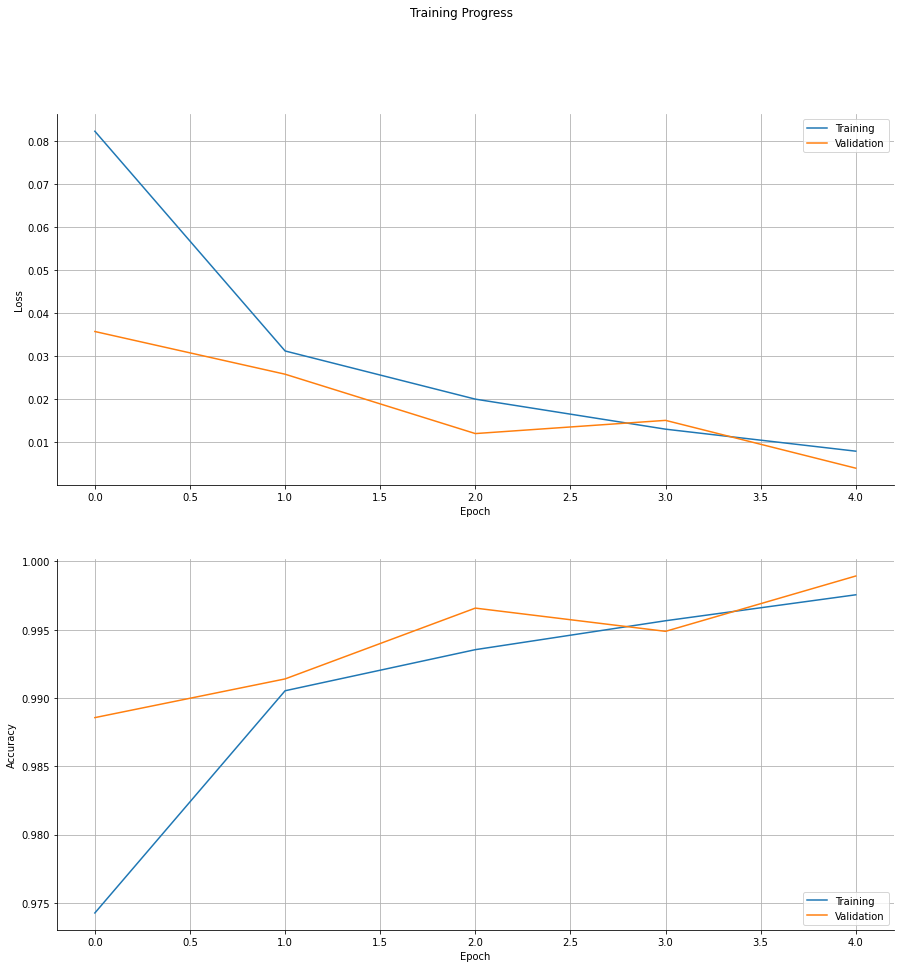

In [11]:
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(15, 15))


x = range(0, EPOCHS)

ax1.plot(x, all_losses_train)
ax1.plot(x, all_val_losses)

fig.suptitle('Training Progress')
ax1.set(xlabel='Epoch', ylabel='Loss')
ax1.legend(['Training', 'Validation'], loc='upper right')
ax1.grid()

ax2.plot(x, all_accuracy_train)
ax2.plot(x, all_val_accuracy)

ax2.set(xlabel='Epoch', ylabel='Accuracy')
ax2.legend(['Training', 'Validation'], loc='lower right')
ax2.grid()

sns.despine()
fig.savefig('cnn_validation_training.pdf')

In [12]:
score = model.evaluate(x_test, y_test, verbose=False)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.05260905250906944
Test accuracy: 0.9883000254631042


In [13]:
Y_test = np.argmax(y_test, axis=1) # Conversão para one-hot 
y_pred = np.argmax(model.predict(x_test), axis=-1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

